## Sonar Returns Dataset
This notebook implements a feed forward neural network using PyTorch to determine if the sonar signals are bounsed off of a metal or a rock. 

**About the data**: Each sonar pattern is a set of 60 numbers between 0 and 1. Each of these 60 numbers represents the energy within a frequency band, integrated over a period of time. Each of these signals are either bounced off of a metal cylinder or a roughly cylindrical rock.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split, DataLoader

import numpy as np
import pandas as pd
import utils

import matplotlib.pyplot as plt
%matplotlib inline

First we will create a class that would represent the dataset and will have both the training data and labels.

In [2]:
class Dataset:
    def __init__(self, path, header = 'infer'):
        '''
        Reads a csv dataset with the assumption that the last column is a categorical label column.
        '''
        self.df = pd.read_csv(path, header = header)
        
        self.data = self.df.values[:, :-1]
        self.data = self.data.astype('float32')
        
        self.labels = self.df.values[:, -1]
        
        # If label is not a number, one-hot encode them
        if not np.issubdtype(self.labels.dtype, np.number):
            self.label_names = []
            for idx, name in enumerate(set(self.labels)):
                self.label_names.append(name)
                self.labels[self.labels == name] = idx
            self.labels = self.labels.astype('float32')
            
        self.labels = self.labels.reshape(-1, 1)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return (self.data[idx], self.labels[idx])
    
    def __repr__(self):
        return repr(self.df)
    
    def split_data(self, test_ratio = 0.3):
        '''
        Splits data into training and test sets.
        '''
        test_len = round(test_ratio * len(self.data))
        train_len = len(self.data) - test_len
        
        return random_split(self, [train_len, test_len])

In [3]:
dataset = Dataset("https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv", header = None)

In [4]:
print(dataset)

         0       1       2       3       4       5       6       7       8   \
0    0.0200  0.0371  0.0428  0.0207  0.0954  0.0986  0.1539  0.1601  0.3109   
1    0.0453  0.0523  0.0843  0.0689  0.1183  0.2583  0.2156  0.3481  0.3337   
2    0.0262  0.0582  0.1099  0.1083  0.0974  0.2280  0.2431  0.3771  0.5598   
3    0.0100  0.0171  0.0623  0.0205  0.0205  0.0368  0.1098  0.1276  0.0598   
4    0.0762  0.0666  0.0481  0.0394  0.0590  0.0649  0.1209  0.2467  0.3564   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
203  0.0187  0.0346  0.0168  0.0177  0.0393  0.1630  0.2028  0.1694  0.2328   
204  0.0323  0.0101  0.0298  0.0564  0.0760  0.0958  0.0990  0.1018  0.1030   
205  0.0522  0.0437  0.0180  0.0292  0.0351  0.1171  0.1257  0.1178  0.1258   
206  0.0303  0.0353  0.0490  0.0608  0.0167  0.1354  0.1465  0.1123  0.1945   
207  0.0260  0.0363  0.0136  0.0272  0.0214  0.0338  0.0655  0.1400  0.1843   

         9   ...      51      52      53      54   

We have succesfully read the dataset as a numpy array. We need to convert them into tensors and create batches of data to feed into our neural network.

Since the data is already normalized to be between 0 and 1, we do not need to perform any more preprocessing steps.

## Logistic Regression

Before training a full-fledged neural netowork, lets first try using logistic regression to see how it performs on this dataset. We can create a logistic regression uisng PyTorch by defining a single neuron with sigmoid activation.

We split the data into 70% training set and 30% test set.

In [5]:
train_data, test_data = dataset.split_data(test_ratio = 0.3)

# Data Loaders for Logistic Regression
train_loader_lr = DataLoader(train_data, batch_size = 1)
test_loader_lr = DataLoader(test_data, batch_size = 1)

In [17]:
# Defining the number of features available in the dataset
N_FEATURES = dataset.data.shape[1]

In [18]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        
        # A single neuron
        self.neuron = nn.Linear(in_features = N_FEATURES, out_features = 1)
        
    def forward(self, x):
        x = self.neuron(x)
        x = torch.sigmoid(x)    # Sigmoid activation on a single neuron, basically makes it logistic regression
        return x

We select L2 loss as our loss function and Stochaistic Gradient descent as optimizer.

To train the model, we run a maximum of 100 epochs. If the change in loss between two epochs falls below some tolerence level, we break out of the loop. 

In [19]:
# Defining loss function and optimizer
lr = LogisticRegression()

loss_fn_lr = nn.MSELoss()
optimizer_lr = optim.SGD(lr.parameters(), lr = 0.001, momentum = 0.9)

In [20]:
# Training our model
loss_hist_lr = []
acc_hist_lr = []
total_train_size = len(train_loader_lr)
TOLERENCE = 0.0001
prev_loss = 0

for epoch in range(100):
    curr_loss = 0
    correct = 0
    for idx, batch in enumerate(train_loader_lr):
        input_data, label = batch
        
        # Forward prop
        output = lr(input_data)
        loss = loss_fn_lr(output, label)
        curr_loss += loss
        
        # Backprop
        optimizer_lr.zero_grad()
        loss.backward()
        optimizer_lr.step()
        
        # Accuracy measure
        if torch.round(output) == label:
            correct += 1
    
    avg_loss = curr_loss / total_train_size
    accuracy = correct / total_train_size
    loss_hist_lr.append(avg_loss)
    acc_hist_lr.append(accuracy)
    
    if abs(avg_loss - prev_loss) < TOLERENCE:
        break
    else:
        prev_loss = avg_loss

In [21]:
print("Train accuracy: {:.4f}".format(round(acc_hist_lr[-1], 4)))
print("Train loss: {:.4f}".format(round(loss_hist_lr[-1].item(), 4)))

Train accuracy: 0.8014
Train loss: 0.1627


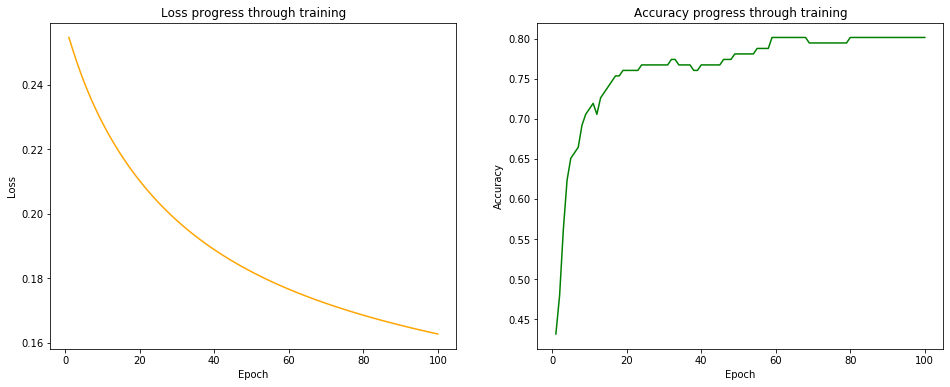

In [22]:
# Plotting the losses and accuracies 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ax[0].plot(range(1, len(loss_hist_lr) + 1), loss_hist_lr, c = 'orange')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss progress through training')

ax[1].plot(range(1, len(acc_hist_lr) + 1), acc_hist_lr, c = 'green')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy progress through training')

plt.show()

Now, we use torch.no_grad() so that we temperoraly stop autograd from tracking history on Tensors and go over all examples in test set to calculate the accuracy.

In [23]:
# Testing the results
lr.eval()
with torch.no_grad():
    correct = 0
    total = len(test_loader_lr)
    total_loss = 0
    for idx, batch in enumerate(test_loader_lr):
        input_data, label = batch
        output = lr(input_data)
        if torch.round(output) == label:
            correct += 1

        loss = loss_fn_lr(output, label)
        total_loss += loss.item()
                    
    print("Test accuracy: {:.4f}".format(round(correct/total, 4)))
    print("Test loss: {:.4f}".format(round(total_loss/total, 4)))

Test accuracy: 0.8226
Test loss: 0.1579


## Feed Forward Neural Network

We got a pretty good accuracy using logistic regression. Now, lets see if we can improve it by using a feed-forward neural network.

In [24]:
# Defining training Parameters
BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 0.005

In [25]:
# Data Loaders for neural network
train_loader = DataLoader(train_data, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE)

Now that we have our data ready, let's create a neural network. This is a very simple architecture where there are only 2 hidden layers with 64 and 16 neurons respectively. Each layer has ReLU activation and the output layer has just one neuron with sigmoid activation to give binary classification.

In [31]:
# Creating a feed forward neural network 
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Hidden Layer 1
        self.layer1 = nn.Sequential(
            nn.Linear(in_features = N_FEATURES, out_features = 64), 
            nn.ReLU())
        
        # Hidden Layer 2
        self.layer2 = nn.Sequential(
            nn.Linear(in_features = 64, out_features = 16), 
            nn.ReLU())
        
        # Output Layer
        self.layer3 = nn.Sequential(
            nn.Linear(in_features = 16, out_features = 1), 
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x

Now that we have our network architecture ready, we need to choose our loss function and optimizer. Once we do that, we just need to train our model.

In [32]:
# Selecting loss function and optimizer
model = Net()

loss_fn = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [33]:
# Training the model
num_train_batches = len(train_loader)
loss_hist = []
acc_hist = []

for epoch in range(1, EPOCHS + 1):
    print("Epoch " + str(epoch) + ": ")
    for idx, batch in enumerate(train_loader):
        # batch is a tuple of data and labels
        inputs, labels = batch
        
        # Running forward pass
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Running backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Measuring accuracy
        total = labels.size(0)
        predicted = torch.round(outputs)
        correct = (predicted == labels).sum().item()
        accuracy = correct / total
        
        # Printing progress
        if (idx % 10 == 9) or (idx == num_train_batches - 1):
            utils.drawProgressBar((idx + 1), num_train_batches, 
                                  '\t loss : {:.4f} \t acc: {:.4f}'.format(round(loss.item(), 4), round(accuracy, 4)))
    print('\n\n')
    acc_hist.append(accuracy)
    loss_hist.append(loss.item())

Epoch 1: 
Progress: [====================] 37/37	 loss : 0.6933 	 acc: 0.5000


Epoch 2: 
Progress: [====================] 37/37	 loss : 0.6650 	 acc: 0.5000


Epoch 3: 
Progress: [====================] 37/37	 loss : 0.5315 	 acc: 0.5000


Epoch 4: 
Progress: [====================] 37/37	 loss : 0.3918 	 acc: 1.0000


Epoch 5: 
Progress: [====================] 37/37	 loss : 0.2927 	 acc: 1.0000


Epoch 6: 
Progress: [====================] 37/37	 loss : 0.2867 	 acc: 1.0000


Epoch 7: 
Progress: [====================] 37/37	 loss : 0.2362 	 acc: 1.0000


Epoch 8: 
Progress: [====================] 37/37	 loss : 0.2152 	 acc: 1.0000


Epoch 9: 
Progress: [====================] 37/37	 loss : 0.2104 	 acc: 1.0000


Epoch 10: 
Progress: [====================] 37/37	 loss : 0.1896 	 acc: 1.0000




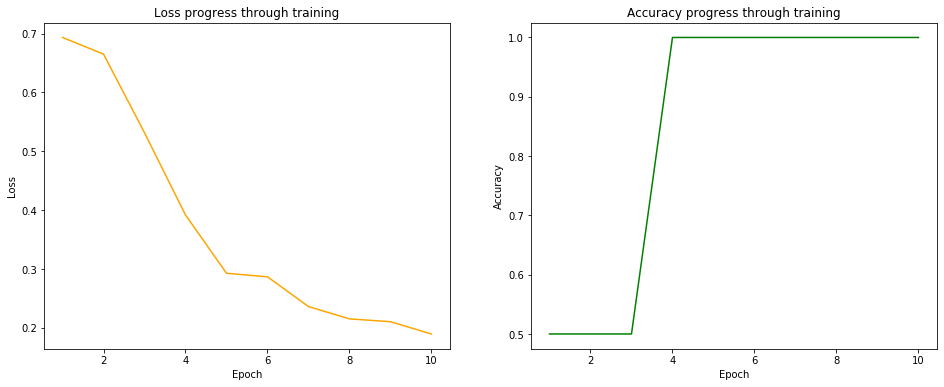

In [34]:
# Plotting the losses and accuracies 
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 6))

ax[0].plot(range(1, len(loss_hist) + 1), loss_hist, c = 'orange')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Loss progress through training')

ax[1].plot(range(1, len(acc_hist) + 1), acc_hist, c = 'green')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy progress through training')

plt.show()

Now we evalute our model on the test set.

First we put our model in evaluate mode using model.eval() so that any Drouput() or BatchNormalization() layers are removed.

Then, we use torch.no_grad() so that we temperoraly stop autograd from tracking history on Tensors and go over all batches in test set to calculate the accuracy.

In [35]:
# Testing the results
model.eval()
num_test_batches = len(test_loader)
with torch.no_grad():
    correct = 0
    total = 0
    total_loss = 0
    for idx, batch in enumerate(test_loader):
        inputs, labels = batch
        outputs = model(inputs)
        predicted = torch.round(outputs)
        loss = loss_fn(outputs, labels)
        total_loss += loss.item()
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Printing progress
        if (idx  % 10 == 9) or (idx == num_test_batches - 1):
            utils.drawProgressBar((idx+1), num_test_batches)
            
    print("\n\nTest accuracy: {:.4f}".format(round(correct/total, 4)))
    print("Test loss: {:.4f}".format(round(total_loss/num_test_batches, 4)))

Progress: [====================] 16/16

Test accuracy: 0.8226
Test loss: 0.4643
